Création du dataset

In [77]:
#Je met les liens des images d'un coté et le folder + id de l'autre
import tensorflow as tf
import numpy as np
import mlflow

base_path = '/Users/orphila_adjovi/PJT6_Open_classrooms_MLE/Images'

image_size = (224, 224)  # Taille images
batch_size = 120  # Taille de lot

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.4,
    subset="training",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.4,
    subset="validation",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)


all_classes = train_ds.class_names
print("Noms des sous-dossiers (class_names) :", all_classes)

test_ds = val_ds.take(len(val_ds) // 2)
val_ds = val_ds.skip(len(val_ds) // 2)

def get_class_proportions(dataset):
    all_labels = []
    for _, labels in dataset.as_numpy_iterator():
        all_labels.extend(labels)

    unique_labels, label_counts = np.unique(all_labels, return_counts=True)
    total_samples = len(all_labels)
    class_proportions = {label: round(count / total_samples,2)*100 for label, count in zip(unique_labels, label_counts)}

    return class_proportions


Found 20580 files belonging to 120 classes.
Using 12348 files for training.
Found 20580 files belonging to 120 classes.
Using 8232 files for validation.
Noms des sous-dossiers (class_names) : ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093

Création de l'échantillon

In [78]:
path_2 = '/Users/orphila_adjovi/PJT6_Open_classrooms_MLE/img'

train_ds_sample = tf.keras.utils.image_dataset_from_directory(
    path_2,
    validation_split=0.4,
    subset="training",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_sample = tf.keras.utils.image_dataset_from_directory(
    path_2,
    validation_split=0.4,
    subset="validation",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

sample_classes = train_ds_sample.class_names
print("Noms des sous-dossiers (class_names) :", sample_classes)

test_ds_sample = val_ds_sample.take(len(val_ds_sample) // 2)
val_ds_sample = val_ds_sample.skip(len(val_ds_sample) // 2)



train_class_proportions = get_class_proportions(train_ds_sample)
print("Proportion des classes dans l'ensemble d'entraînement :", train_class_proportions)
val_class_proportions = get_class_proportions(val_ds_sample)
print("Proportion des classes dans l'ensemble de validation :", val_class_proportions)
test_class_proportions = get_class_proportions(test_ds_sample)
print("Proportion des classes dans l'ensemble de test :", test_class_proportions)



Found 497 files belonging to 3 classes.
Using 299 files for training.
Found 497 files belonging to 3 classes.
Using 198 files for validation.
Noms des sous-dossiers (class_names) : ['n02085620-Chihuahua', 'n02088364-beagle', 'n02099601-golden_retriever']
Proportion des classes dans l'ensemble d'entraînement : {0: 30.0, 1: 40.0, 2: 28.999999999999996}
Proportion des classes dans l'ensemble de validation : {0: 32.0, 1: 40.0, 2: 28.000000000000004}
Proportion des classes dans l'ensemble de test : {0: 30.0, 1: 44.0, 2: 26.0}


Création du premier CNN

In [79]:
# Fonctions de prétraitement
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]
data_augmentation_2_layers = [
    layers.RandomZoom(0.2),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


def data_augmentation_2(images):
    for layer in data_augmentation_2_layers:
        images = layer(images)
    return images

#Scaling du nombre de pixels 
def data_standardisation(images):
    """output = (input-offset)/scale, offset à zéro"""
    images = layers.Rescaling(scale=1.5)(images)
    return images

def convert_to_grayscale(images):
    if images.shape[-1] == 3:
        grayscale_images = tf.image.rgb_to_grayscale(images)
        return grayscale_images
    else:
        return images

In [80]:
#modèle 1
from tensorflow import keras
from tensorflow.keras.layers import Conv2D


# Création du modèle
model = keras.Sequential([
    # Couches de prétraitement
    layers.Lambda(convert_to_grayscale),
    layers.Lambda(data_standardisation),
    
    # Couches de convolution et de pooling
    Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Transition vers les couches denses
    layers.Flatten(),
    # Couches denses
    layers.Dense(512, activation='relu'),
    layers.Dense(120, activation='softmax') 
])

Fit, test et evaluation du 1er modèle 

In [98]:
# 1er modèle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import mlflow
mlflow.tensorflow.autolog()

def train_model(mdl, train_ens, val_ens, test_ens, optimizer,name):
    class_ens = train_ens.class_names
    mdl.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    # Commencer une expérience MLflow
    with mlflow.start_run(run_name = name):
        """
        mlflow.tensorflow.log_model(
            model=mdl,
            artifact_path='model',
            registered_model_name="cnn "+name,
            input_example=test_ens.take(1),  # Exemple d'entrée pour l'enregistrement)
        """
        mlflow.tensorflow.log_model(model, artifact_path="cnn-model",input_example=test_ens.take(1),signature=False)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("epochs", 3)

        mdl.fit(train_ens, validation_data=val_ens, epochs=3)
        # Prédiction pour l'ensemble de test
        y_pred = mdl.predict(test_ens)
        # Convertir les prédictions en classes
        y_pred_classes = np.argmax(y_pred, axis=1)
        # Convertir les étiquettes de l'ensemble de test en classes
        y_true = np.concatenate([y for x, y in test_ens], axis=0)
        """
        # Calculer la matrice de confusion
        cm = confusion_matrix(y_true, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, cmap="Reds",xticklabels=class_ens, yticklabels=class_ens)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Matrice de Confusion - Ensemble de Test')
        plt.show()
        """
        # Évaluer l'exactitude sur l'ensemble de test
        accuracy = mdl.evaluate(test_ens, verbose=0)[1]
        print(f"Précision sur le test: {accuracy}")
        mlflow.log_metric("accuracy", accuracy)

    return mdl


first_cnn_from_scratch = train_model(model, train_ds_sample, val_ds_sample, test_ds_sample, 'adam',"first_cnn_from_scratch")

2024/02/09 18:23:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


ValueError: Model <keras.src.engine.sequential.Sequential object at 0x7fe5be837190> cannot be saved because the input shape is not available. Please specify an input shape either by calling `build(input_shape)` directly, or by calling the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`.

Amélioration du modèle

In [ ]:
model_2 = keras.Sequential([
    # Couches de prétraitement
    layers.Lambda(convert_to_grayscale),
    layers.Lambda(data_standardisation),
    layers.Lambda(data_augmentation),

    # Couches de convolution et de pooling
    Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Transition vers les couches denses
    layers.Flatten(),

    # Couches denses
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),  # Ajout d'une couche de dropout pour la régularisation
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),  # Ajout d'une autre couche de dropout
    layers.Dense(120, activation='softmax') 
])

cnn_with_data_augmentation = train_model(model_2,train_ds_sample,val_ds_sample, test_ds_sample,'adam',"cnn_with_data_augmentation")

Epoch 1/3
3/3 [==============================] - 14s 4s/step - loss: 39.8289 - accuracy: 0.1739 - val_loss: 31.3713 - val_accuracy: 0.3590
Epoch 2/3
3/3 [==============================] - 14s 4s/step - loss: 15.2642 - accuracy: 0.3579 - val_loss: 1.9805 - val_accuracy: 0.2436
Epoch 3/3
1/1 [==============================] - 1s 1s/step
Précision sur le test: 0.3083333373069763


Ajout de la 2eme data augment

In [ ]:
model_2_1 = keras.Sequential([
    # Couches de prétraitement
    layers.Lambda(convert_to_grayscale),
    layers.Lambda(data_standardisation),
    layers.Lambda(data_augmentation),
    layers.Lambda(data_augmentation_2),

    # Couches de convolution et de pooling
    Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Transition vers les couches denses
    layers.Flatten(),

    # Couches denses
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Ajout d'une couche de dropout pour la régularisation
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Ajout d'une autre couche de dropout
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Ajout d'une autre couche de dropout
    layers.Dense(120, activation='softmax') 
])

cnn_with_data_augmentation_2 = train_model(model_2_1,train_ds_sample,val_ds_sample,test_ds_sample,"adam","cnn_with_data_augmentation_2")

Epoch 1/3


3/3 [==============================] - 17s 4s/step - loss: 63.1546 - accuracy: 0.0502 - val_loss: 1.9580 - val_accuracy: 0.4231
Epoch 2/3
3/3 [==============================] - 13s 4s/step - loss: 5.2117 - accuracy: 0.2007 - val_loss: 1.4058 - val_accuracy: 0.3590
Epoch 3/3
1/1 [==============================] - 1s 1s/step
Précision sur le test: 0.4333333373069763


Optimisation des hyperparamètres avec optuna

In [ ]:
import optuna
from tensorflow.keras.optimizers import Adam

def objective(trial):
    # Paramètres à optimiser
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    num_epochs = trial.suggest_int('num_epochs', 5, 10)

    # Création du modèle avec les paramètres suggérés
    model = keras.Sequential([
        # Couches de prétraitement
        layers.Lambda(convert_to_grayscale),
        layers.Lambda(data_standardisation),
        layers.Lambda(data_augmentation),
        layers.Lambda(data_augmentation_2),

        # Couches de convolution et de pooling
        Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Transition vers les couches denses
        layers.Flatten(),

        # Couches denses
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(120, activation='softmax') 
    ])

    # Compilation du modèle avec l'optimiseur Adam et le taux d'apprentissage
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    # Entraînement du modèle
    model.fit(train_ds_sample, validation_data=val_ds_sample, epochs=num_epochs, verbose=0)

    # Évaluation du modèle sur l'ensemble de validation
    _, accuracy = model.evaluate(val_ds_sample)
    
    return accuracy

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Affichage des résultats
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-02-09 17:50:46,587] A new study created in memory with name: no-name-4a6fd0ba-96e1-4035-94c2-948463468761


1/1 [==============================] - 1s 880ms/step - loss: 4.6415 - accuracy: 0.2692


[I 2024-02-09 17:52:01,231] Trial 0 finished with value: 0.26923078298568726 and parameters: {'dropout_rate': 0.2690204970671646, 'learning_rate': 0.007577897859527736, 'num_epochs': 6}. Best is trial 0 with value: 0.26923078298568726.


1/1 [==============================] - 1s 1s/step - loss: 1.0790 - accuracy: 0.4231


[I 2024-02-09 17:54:27,509] Trial 1 finished with value: 0.42307692766189575 and parameters: {'dropout_rate': 0.29879410947390456, 'learning_rate': 0.004114869825661203, 'num_epochs': 8}. Best is trial 1 with value: 0.42307692766189575.
[W 2024-02-09 17:55:57,488] Trial 2 failed with parameters: {'dropout_rate': 0.23512701347961015, 'learning_rate': 0.003382643919374594, 'num_epochs': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/orphila_adjovi/PJT6_Open_classrooms_MLE/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/_l/cjjst_c50lx2nkkr280zbp440000gp/T/ipykernel_1306/1786292663.py", line 48, in objective
    model.fit(train_ds_sample, validation_data=val_ds_sample, epochs=num_epochs, verbose=0)
  File "/Users/orphila_adjovi/PJT6_Open_classrooms_MLE/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in erro

KeyboardInterrupt: 

Epoch 1/10


3/3 [==============================] - 19s 4s/step - loss: 21.7162 - accuracy: 0.1973 - val_loss: 4.1623 - val_accuracy: 0.3077
Epoch 2/10
3/3 [==============================] - 12s 4s/step - loss: 5.7491 - accuracy: 0.3512 - val_loss: 1.4556 - val_accuracy: 0.3718
Epoch 3/10
3/3 [==============================] - 13s 4s/step - loss: 1.8416 - accuracy: 0.3679 - val_loss: 1.4318 - val_accuracy: 0.4359
Epoch 4/10
3/3 [==============================] - 15s 5s/step - loss: 1.6640 - accuracy: 0.4013 - val_loss: 1.3193 - val_accuracy: 0.3718
Epoch 5/10
3/3 [==============================] - 14s 4s/step - loss: 1.5037 - accuracy: 0.3612 - val_loss: 1.0844 - val_accuracy: 0.4103
Epoch 6/10
3/3 [==============================] - 11s 3s/step - loss: 1.3856 - accuracy: 0.3746 - val_loss: 1.1378 - val_accuracy: 0.4103
Epoch 7/10
3/3 [==============================] - 12s 4s/step - loss: 1.4019 - accuracy: 0.3445 - val_loss: 1.0947 - val_accuracy: 0.4359
Epoch 8/10
3/3 [============================

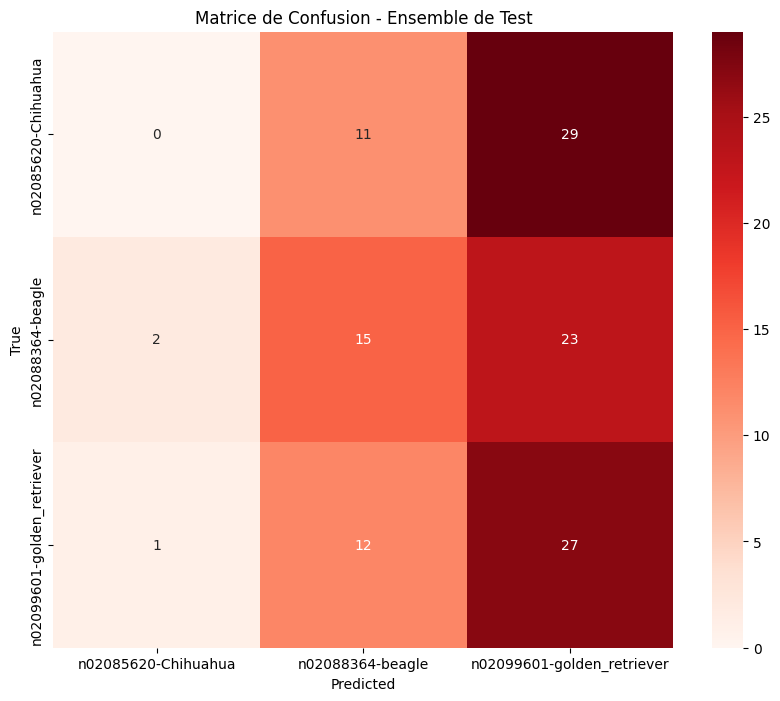

Précision sur le test: 0.44999998807907104


In [ ]:
#modèle optimisé
dropout_rate = 0.2570433990346258
learning_rate = 0.0005703961594509845

model_3 = keras.Sequential([
    # Couches de prétraitement
    layers.Lambda(convert_to_grayscale),
    layers.Lambda(data_standardisation),
    layers.Lambda(data_augmentation),
    layers.Lambda(data_augmentation_2),

    # Couches de convolution et de pooling
    Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Transition vers les couches denses
    layers.Flatten(),

    # Couches denses
    layers.Dense(512, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(256, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(256, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(120, activation='softmax') 
])

cnn_from_scratch_optimized = train_model(model_3,train_ds_sample,val_ds_sample,test_ds_sample,Adam(learning_rate=learning_rate),"cnn_from_scratch_optimized")